This notebook performs the following tasks:

5.1 [Classify same-day permits](#5.1)


5.2 [Regress non-same-day permits](#5.2)

Kush did tasks 5.1-5.2. 

In [1]:
# Data tools
import pandas as pd
import matplotlib.pyplot as plt

# ML tools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor

In [3]:
train = pd.read_csv('data/data_train_clean1.csv')
test = pd.read_csv('data/data_test_clean1.csv')

In [4]:
train.shape

(159120, 45)

In [5]:
test.shape

(39780, 45)

# 5.1 Classify same-day permits
<a id='5.1'></a>

In [6]:
def features(data):
    permit_type = np.array(pd.get_dummies(data['Permit Type']))
    #existing_constrxn = np.array(pd.get_dummies(data['Existing Construction Type']))
    #proposed_constrxn = np.array(pd.get_dummies(data['Proposed Construction Type']))
    #existing_use = np.array(pd.get_dummies(data['Existing Use']))
    #proposed_use = np.array(pd.get_dummies(data['Proposed Use']))
    plansets = np.array(pd.get_dummies(data['Plansets']))

    existing_units = np.array(data['Existing Units'])
    #proposed_units = np.array(data['Proposed Units'])
    fire_only = np.array(data['Fire Only Permit'])
    #est_cost = np.array(data['Estimated Cost'])
    #retrofit = np.array(data['Voluntary Soft-Story Retrofit'])

    X = np.column_stack((permit_type,
                         #existing_constrxn, #proposed_constrxn,
                         #existing_use, #proposed_use,
                         plansets,
                         existing_units, #proposed_units,
                         fire_only))#, est_cost, retrofit))
    
    print(f"Features have shape {X.shape}")
    return X

In [7]:
# temporarily bind train and test so that features are guaranteed to align
# b/c test set doesn't necessarily contain an instance of every category. 
n_tr, _ = train.shape
data = pd.concat([train, test])
X = features(data)

X_tr = X[:n_tr,:]
X_te = X[n_tr:,:]

print(X_tr.shape)
print(X_te.shape)

Features have shape (198900, 15)
(159120, 15)
(39780, 15)


In [8]:
def simple_impute(X, dtype="real"):
    _, d = X.shape
    for j in range(d):
        feature = X[:,j]
        nan_inds = np.isnan(feature)
        median = np.median(feature[~nan_inds])
        X[:,j][nan_inds] = median
    return X

In [9]:
X_tr_hat = simple_impute(X_tr)

In [10]:
X_te_hat = simple_impute(X_te)

**OR smarter imputation in notebook "5 - GLRM"**

In [22]:
# send to Julia code for GLRM
# np.savetxt("X_tr.csv", X_tr, delimiter=",")
# np.savetxt("X_te.csv", X_te, delimiter=",")

In [ ]:
#X_tr_hat = np.loadtxt("X_tr_hat.csv", delimiter=",") # GLRM-imputed data
#X_te_hat = np.loadtxt("X_te_hat.csv", delimiter=",") # GLRM-imputed data from training set's W matrix

Back to problem

In [11]:
y_tr = np.array(train['Days to issue'])
y_te = np.array(test['Days to issue'])

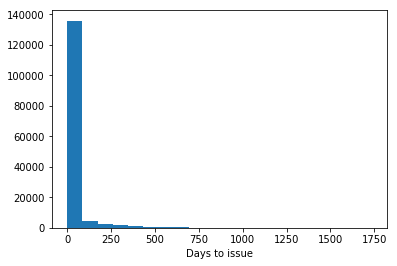

In [32]:
plt.hist(y_tr, bins=20)
plt.xlabel("Days to issue");

In [12]:
def filter_unissued(X, y):
    unissued_permits = np.isnan(y)
    X = X[~unissued_permits,:]
    y = y[~unissued_permits]
    return X, y

In [13]:
X_tr_hat, y_tr = filter_unissued(X_tr_hat, y_tr)
X_te_hat, y_te = filter_unissued(X_te_hat, y_te)

print(X_tr_hat.shape)
print(y_tr.shape)

(147226, 15)
(147226,)


In [14]:
print(X_te_hat.shape)
print(y_te.shape)

(36734, 15)
(36734,)


In [15]:
def binarize_label(y):
    baseline = sum(y == 0)/len(y)
    print(f"Baseline accuracy = {baseline}")
    
    y_bin = y.copy()
    y_bin[y_bin > 0] = 1
    return y_bin

In [16]:
y_tr_bin = binarize_label(y_tr)
y_te_bin = binarize_label(y_te)

Baseline accuracy = 0.6270495700487686
Baseline accuracy = 0.6307508030707246


Mini trial before running on full training and test sets

In [17]:
n_sample = 30000
rand_permits = np.random.randint(0, len(y_tr_bin), n_sample)
X_sample = X_tr_hat[rand_permits,:]
y_sample = y_tr_bin[rand_permits]

X_sample_tr, X_sample_te, y_sample_tr, y_sample_te = train_test_split(X_sample, y_sample, test_size=0.2)

In [18]:
def svm(X_tr, X_te, y_tr, y_te):
    clf = SVC(C=1.0, gamma='auto')
    clf.fit(X_tr, y_tr)
    
    train_acc = clf.score(X_tr, y_tr) 
    test_acc  = clf.score(X_te, y_te)
    print(f"Training accuracy = {train_acc}")
    print(f"Test accuracy     = {test_acc}")
    return clf

In [19]:
clf_sample = svm(X_sample_tr, X_sample_te, y_sample_tr, y_sample_te)

Training accuracy = 0.872875
Test accuracy     = 0.872


The SVM can classify same-day permits well&mdash;about 25% better than the constant model. So now train the full model, which takes a very long time. 

In [20]:
clf = svm(X_tr_hat, X_te_hat, y_tr_bin, y_te_bin)

Training accuracy = 0.8783231222745982
Test accuracy     = 0.8803016279196385


In [31]:
confusion_matrix(clf.predict(X_te_hat), y_te_bin)

array([[21014,  2241],
       [ 2156, 11323]], dtype=int64)

# 5.2 Regress non-same-day permits
<a id='5.2'></a>

In [23]:
def filter_sameday(X, y):
    sameday_permits = (y == 0)
    X = X[~sameday_permits,:]
    y = y[~sameday_permits]
    return X, y

In [24]:
# "nsp" denotes "non-same-day permit"
X_tr_hat_nsp, y_tr_nsp = filter_sameday(X_tr_hat, y_tr)
X_te_hat_nsp, y_te_nsp = filter_sameday(X_te_hat, y_te)

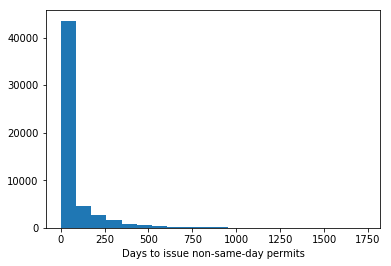

In [25]:
# still overdispersed
plt.hist(y_tr_nsp, bins=20)
plt.xlabel("Days to issue non-same-day permits");

In [26]:
regr = RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=5)
regr.fit(X_tr_hat_nsp, y_tr_nsp)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
def summarize_acc(X, y):
    R_sq = regr.score(X, y)
    pred = np.maximum(regr.predict(X), 1)
    MAE = np.mean(np.abs(pred-y))
    MSE = np.mean((pred-y)**2)
    RMSE = MSE**0.5
    
    print(f"R^2  = {R_sq}")
    print(f"MAE  = {MAE}")
    print(f"RMSE = {RMSE}")

    # is underfitting local?
    plt.scatter(pred, y)
    plt.xlabel("Prediction")
    plt.ylabel("Observation")

R^2  = 0.36324224709411923
MAE  = 48.13293682159248
RMSE = 111.1316869955916


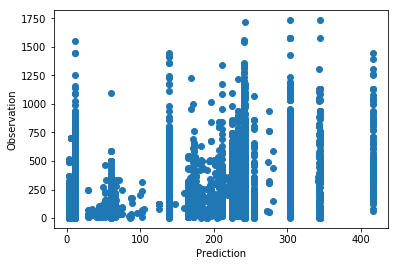

In [36]:
summarize_acc(X_tr_hat_nsp, y_tr_nsp)

R^2  = 0.36915492296652996
MAE  = 47.49903015334709
RMSE = 107.78930060271801


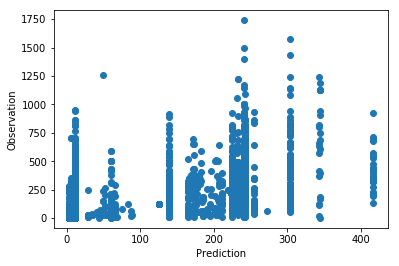

In [37]:
summarize_acc(X_te_hat_nsp, y_te_nsp)

Still experiencing severe underfitting. If we wanted to be fancier, we could use a zero-inflation GLM with a negative-binomial distribution, since the response is overdispersed. But experiments in R did not yield much improvement.  

In [33]:
print(f"Mean days to issue     = {np.mean(y_tr_nsp)}")
print(f"Variance days to issue = {np.var(y_tr_nsp)}")

Mean days to issue     = 70.25861440955781
Variance days to issue = 19395.526474746563


In [34]:
print(f"Mean days to issue     = {np.mean(y_tr)}")
print(f"Variance days to issue = {np.var(y_tr)}")

Mean days to issue     = 26.20298045182237
Variance days to issue = 8387.958853274404
